## Explore the regulatary relationship between gene expression and flux among different reaction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from scipy.stats import pearsonr
import random

os.chdir(r'D:\code\github\Unified_Yeast_GEMs_Database')

In [2]:
#load data
# expression data
expressionMatrix=pd.read_csv(r'code\6.transcriptomics_ssGEMs_analysis\output\sce969_rxn_expressionMatrix_normalized.csv',index_col=0)
# flux data
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/fix_growth_gimme_fba_fluxes_shrinked_noyeast9.csv',index_col=0)
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/riptide_ssGEMs_growth0.2_ethanolyield0.25_median_flux.csv',index_col=0)
fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/fix_growth1.3_gimme_fba_fluxes_shrinked.csv',index_col=0)
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/fix_growth1_gimme_fba_fluxes.csv',index_col=0)
# normalize flux data
# fluxMatrix=fluxMatrix.div(fluxMatrix.loc['r_1714',:],axis=1)*(-100)
fluxMatrix=fluxMatrix.loc[:,fluxMatrix.loc['r_2111',:]>0]
# fill the NaN value with 0
fluxMatrix=fluxMatrix.fillna(0)
# set absolute value of fluxes
fluxMatrix=fluxMatrix.abs()
# fill all value <0.00001 as 0
fluxMatrix[fluxMatrix<0.00001]=0

# remove rows that 99% values are 0
expressionMatrix=expressionMatrix.loc[(expressionMatrix.T!=0).sum()>0.01*expressionMatrix.shape[1],:]
fluxMatrix=fluxMatrix.loc[(fluxMatrix.T!=0).sum()>0.01*fluxMatrix.shape[1],:]

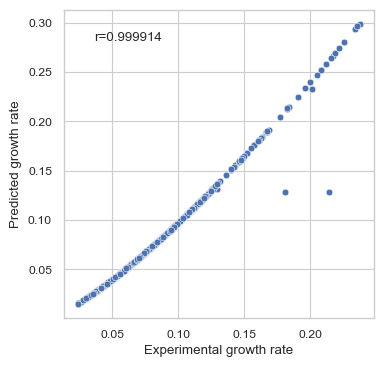

In [3]:
# evaluate the predicted growth rate with the experimental data
growth='r_2111'
pre_growth = fluxMatrix.loc[growth, :]
# remove 0 value
pre_growth = pre_growth[pre_growth != 0]
# load experimental growth rate
# load growth data
df_exp_data = pd.read_csv('data/transcriptomics/combined_969growth_data.csv', index_col=0)
# remove rows with genome_id is NaN
df_exp_data = df_exp_data[df_exp_data['genome_id'].notnull()]
# set genome_id as index
df_exp_data = df_exp_data.set_index('genome_id')
exp_growth = df_exp_data['t_mid_norm']

df_growth=pd.DataFrame(index=pre_growth.index)
df_growth['pre']=pre_growth
df_growth['exp']=df_growth.index.map(exp_growth)
# remove rows with NaN
df_growth=df_growth[df_growth['exp'].notnull()]
# remove predicted growth rate < 0.15
# df_growth=df_growth[df_growth['pre']>0.15]
df_growth['exp']=1/df_growth['exp']

# plot the predicted vs experimental growth rate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper')
plt.figure(figsize=(4,4))
sns.scatterplot(x='exp',y='pre',data=df_growth)
plt.xlabel('Experimental growth rate')
plt.ylabel('Predicted growth rate')
# calculate the correlation coefficient
from scipy.stats import spearmanr
r,p=spearmanr(df_growth['exp'],df_growth['pre'])
plt.text(0.1,0.9,'r=%f' %r,transform=plt.gca().transAxes)
plt.show()

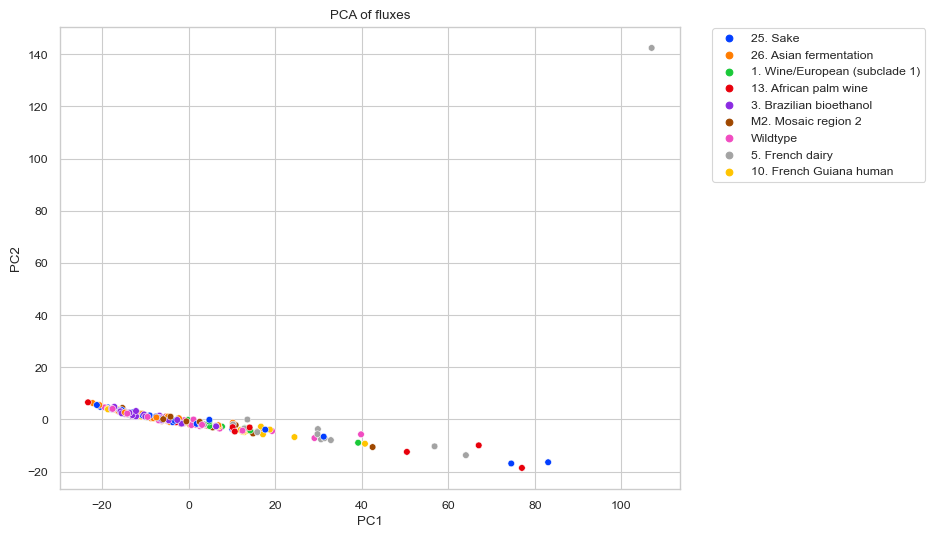

In [4]:
# plot the PCA of the flux data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data=fluxMatrix.T
# load all strain info
df_strain_info=pd.read_excel(r'data\1897_strains_info.xlsx',index_col=0)
# remove duplicated index
df_strain_info=df_strain_info[~df_strain_info.index.duplicated()]
data['Type']=df_strain_info['nature_clade']
wildtypelist=['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ', '24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian ']
data['Type']=data['Type'].apply(lambda x: 'Wildtype' if x in wildtypelist else x)
keep_clades=data['Type'].value_counts().index[(data['Type'].value_counts()>15)&(data['Type'].value_counts()<40)].tolist()
to_ignores=['1. Wine/European (subclade 4)','1. Wine/European (subclade 3)','8. Mixed origin ']
keep_clades=[x for x in keep_clades if x not in to_ignores]
data=data[data['Type'].isin(keep_clades)]

x1 = StandardScaler().fit_transform(data.drop('Type',axis=1))

# PCA
pca1 = PCA(n_components=2)
principalComponents1 = pca1.fit_transform(x1)

# plot
fig,ax=plt.subplots(figsize=(8,6))
# plot geneMatrix
pca_fluxes=pd.DataFrame(principalComponents1,columns=['PC1','PC2'])
pca_fluxes['Type']=data['Type'].values
sns.scatterplot(x='PC1',y='PC2',hue='Type',data=pca_fluxes,ax=ax,palette='bright')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
# set title
ax.set_title('PCA of fluxes')

# set legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

In [5]:
common_strains=expressionMatrix.columns.intersection(fluxMatrix.columns)
common_rxns=expressionMatrix.index.intersection(fluxMatrix.index)

expressionMatrix=expressionMatrix.loc[common_rxns,common_strains]
fluxMatrix=fluxMatrix.loc[common_rxns,common_strains]

# z-score normalization
def z_score_convert(df):
    return df.apply(lambda x:(x-x.mean())/x.std(),axis=1)

flux_z_Matrix=z_score_convert(fluxMatrix)
expression_z_Matrix=z_score_convert(expressionMatrix)
# flux_z_Matrix=fluxMatrix
# expression_z_Matrix=expressionMatrix

# remove rows that 99% values are NaN
expression_z_Matrix=expression_z_Matrix.loc[(expression_z_Matrix.T.isna()).sum()<0.01*expression_z_Matrix.shape[1],:]
flux_z_Matrix=flux_z_Matrix.loc[(flux_z_Matrix.T.isna()).sum()<0.01*flux_z_Matrix.shape[1],:]

common_strains=expression_z_Matrix.columns.intersection(flux_z_Matrix.columns)
common_rxns=expression_z_Matrix.index.intersection(flux_z_Matrix.index)

expression_z_Matrix=expression_z_Matrix.loc[common_rxns,common_strains]
flux_z_Matrix=flux_z_Matrix.loc[common_rxns,common_strains]


In [6]:
# calculate the correlation between flux and expression
def calculate_correlation(df1,df2):
    common_rxnList=df1.index.intersection(df2.index)
    
    df_correlation=pd.DataFrame(index=common_rxnList,columns=['correlation','p-value'])
    for rxn in common_rxnList:
        # option 1: use pearsonr correlation
        # df_correlation.loc[rxn,'correlation'],df_correlation.loc[rxn,'p-value']=pearsonr(df1.loc[rxn,:],df2.loc[rxn,:])
        # option 2: use spearman correlation
        from scipy.stats import spearmanr
        df_correlation.loc[rxn,'correlation'],df_correlation.loc[rxn,'p-value']=spearmanr(df1.loc[rxn,:],df2.loc[rxn,:])

    df_correlation=df_correlation.astype(float)
    # fill nan value with 0 in correlation column
    df_correlation['correlation']=df_correlation['correlation'].fillna(0)

    # fill p-value > 0.05 with 0 in correlation column
    # df_correlation=df_correlation.loc[df_correlation['p-value']<0.05,:]
    df_correlation.loc[df_correlation['p-value']>0.05,'correlation']=0
    return df_correlation

flux_expression_r=calculate_correlation(flux_z_Matrix,expression_z_Matrix)

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [7]:
# check the correlation distribution that p-value<0.05
flux_expression_r['correlation'].describe()
# # sort according to the correlation value
flux_expression_r.sort_values(by='correlation',ascending=False,inplace=True)
# fluxMatrix.loc[flux_expression_r.index[:5]].T.describe()
# save flux_expression_r
# flux_expression_r.to_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/flux_expression_correlation.csv')
flux_expression_r['correlation'].describe()

count    778.000000
mean       0.020619
std        0.073947
min       -0.465673
25%        0.000000
50%        0.000000
75%        0.000000
max        0.541066
Name: correlation, dtype: float64

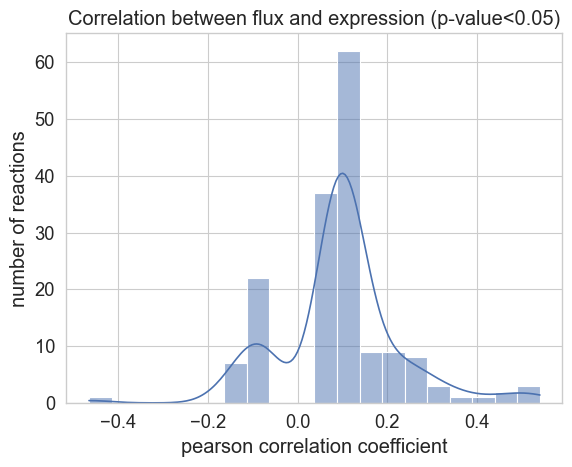

In [8]:
# plot the distribution of correlation
# plot the kde and histogram for flux_expression_r
sns.set_theme(context='paper',style='whitegrid',palette='deep',font='Arial',font_scale=1.5)
sns.histplot(flux_expression_r.loc[flux_expression_r['p-value']<0.05,'correlation'],kde=True,bins=20)
plt.xlabel('pearson correlation coefficient')
plt.ylabel('number of reactions')
plt.title('Correlation between flux and expression (p-value<0.05)')
# set x axis limit
# plt.xlim(-1,1)
plt.show()

In [9]:
# do the enrichment analysis
import gseapy as gp
from gseapy import dotplot

In [10]:
# load reaction pathway dict
import cobra
model=cobra.io.read_sbml_model(r'model/yeast-GEM.xml')
pathway_dict={}
availuable_rxns=flux_z_Matrix.index.tolist()
for group in model.groups:
    name=group.name
    # ignore Transport
    if 'Transport' in name:
        continue
    rxnIDlist=[rxn.id for rxn in group.members if rxn.id in availuable_rxns]
    pathway_dict[name]=rxnIDlist

In [11]:
top_correlation_rxns=flux_expression_r.loc[flux_expression_r['correlation']>0.2].index.tolist()
top_correlation_rxns

['r_1267',
 'r_0659',
 'r_2118',
 'r_4226',
 'r_2119',
 'r_0308',
 'r_1184',
 'r_1273',
 'r_1126',
 'r_0445',
 'r_1075',
 'r_0191',
 'r_0508',
 'r_0507',
 'r_0506',
 'r_1128',
 'r_4484',
 'r_0032',
 'r_0303',
 'r_2305',
 'r_1192',
 'r_2117',
 'r_0662',
 'r_0883',
 'r_0509',
 'r_0504']

In [12]:
# do enrichment analysis
enr=gp.enrichr(gene_list=top_correlation_rxns,
               gene_sets=pathway_dict,
               background=fluxMatrix.index.tolist(),
               )
enr.results.sort_values(by='Adjusted P-value',ascending=True,inplace=True)

# save enr.result
enr.results.to_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/flux&expression_enrichment_analysis.csv')
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
4,gs_ind_0,"Glycine, serine and threonine metabolism",5/24,0.000770,0.004301,9.622540,68.979897,r_0507;r_0504;r_0506;r_0509;r_0508
5,gs_ind_0,Glyoxylate and dicarboxylate metabolism,2/2,0.001075,0.004301,153.571429,1049.690586,r_0662;r_0445
7,gs_ind_0,Sulfur metabolism,2/4,0.006188,0.016503,30.632653,155.769123,r_0032;r_0883
6,gs_ind_0,"Phenylalanine, tyrosine and tryptophan biosynt...",3/15,0.011559,0.023118,8.822979,39.353159,r_2118;r_2117;r_2119
2,gs_ind_0,Citrate cycle (TCA cycle),3/17,0.016520,0.026432,7.585473,31.124729,r_0303;r_0659;r_2305
3,gs_ind_0,Cysteine and methionine metabolism,2/9,0.033482,0.044642,10.142857,34.452837,r_4484;r_0308
1,gs_ind_0,Arginine biosynthesis,2/10,0.041000,0.046857,8.937575,28.548340,r_0191;r_1075
0,gs_ind_0,"Alanine, aspartate and glutamate metabolism",1/12,0.336910,0.336910,3.792839,4.126374,r_4226


<AxesSubplot:title={'center':'Highly correlated reactions'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

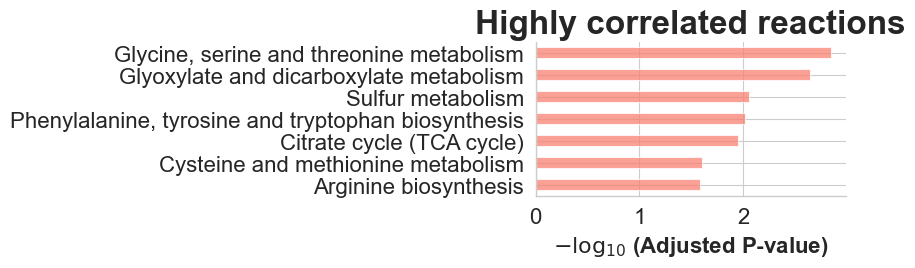

In [534]:
from gseapy import barplot

barplot(enr.results,
                column='Adjusted P-value',
                    title='Highly correlated reactions',cutoff=0.05,figsize=(4,2))

2024-11-25 09:07:30,783 [WARNING] Duplicated values found in preranked stats: 57.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-11-25 09:07:30,783 [INFO] Parsing data files for GSEA.............................
2024-11-25 09:07:30,784 [INFO] 0044 gene_sets have been filtered out when max_size=1000 and min_size=3
2024-11-25 09:07:30,785 [INFO] 0034 gene_sets used for further statistical testing.....
2024-11-25 09:07:30,785 [INFO] Start to run GSEA...Might take a while..................
2024-11-25 09:07:30,834 [INFO] Congratulations. GSEApy runs successfully................



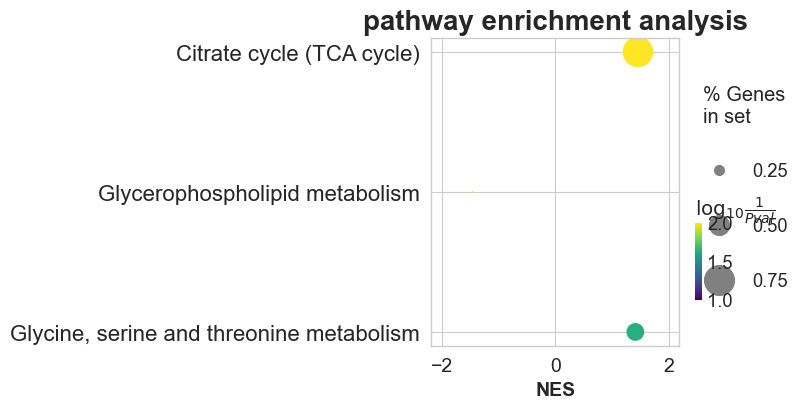

In [14]:
# propare the pre-ranked gene list
df_gene_list=flux_expression_r['correlation'].sort_values(ascending=False)
df_gene_list=pd.DataFrame(df_gene_list)

# do the gsea analysis
pre_res = gp.prerank(rnk=df_gene_list, # or rnk = rnk,
                     gene_sets=pathway_dict,
                     min_size=3,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

pre_res.res2d.sort_values(by='NOM p-val',ascending=True)

# plot
ax = dotplot(pre_res.res2d,
             column="NOM p-val", 
            #  column='FDR q-val',
             title='pathway enrichment analysis',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(4,4), 
             cutoff=0.05,
             show_ring=False)

### 2.Difference of transcription&flux regulation among different growth type

In [535]:
# extract strains for different growth type
df_growth_data=pd.read_csv('data/transcriptomics/combined_969growth_data.csv',index_col=0)
# remove rows with genome_id is NaN
df_growth_data=df_growth_data[df_growth_data['genome_id'].notnull()]
#set genome_id as index
df_growth_data=df_growth_data.set_index('genome_id')

# only keep strains exist in rxn_fcMatrix column and df_strain_info index
df_growth_data=df_growth_data[df_growth_data.index.isin(common_strains)]

# sort by t_mid_norm
df_growth_data=df_growth_data.sort_values(by=['t_mid_norm'])

# extract top 50 as fast , bottom 50 as slow, and middle 50 as medium
middle_num=math.floor(df_growth_data.shape[0]/2)
fast_strainlist=df_growth_data.index[:50].tolist()
medium_strainlist=df_growth_data.index[middle_num-25:middle_num+25].tolist()
slow_strainlist=df_growth_data.index[-50:].tolist()

In [536]:
def calculate_subpop_correlation(df1,df2,strainlist):
    df1=df1.loc[:,strainlist]
    df2=df2.loc[:,strainlist]
    
    return calculate_correlation(df1,df2)

fast_flux_expression_r=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,fast_strainlist)
medium_flux_expression_r=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,medium_strainlist)
slow_flux_expression_r=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,slow_strainlist)

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [537]:
df_growth_type_corr=pd.DataFrame({'fast':fast_flux_expression_r['correlation'],'medium':medium_flux_expression_r['correlation'],'slow':slow_flux_expression_r['correlation']})
# fill nan value with 0
df_growth_type_corr=df_growth_type_corr.fillna(0)
df_growth_type_corr.describe()

,fast,medium,slow
count,778.000000,778.000000,778.000000
mean,0.003064,0.014650,0.007472
std,0.084930,0.089930,0.104302
min,-0.473527,-0.414312,-0.492115
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.503898,0.638978,0.734932


fast 0.009073062659813537
medium 1.0
slow 0.1461927063984553


C:\Users\wangh\AppData\Local\Temp\ipykernel_14308\4240168129.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_growth_type_corr.loc[~(df_growth_type_corr==0).all(axis=1)],shade=True)


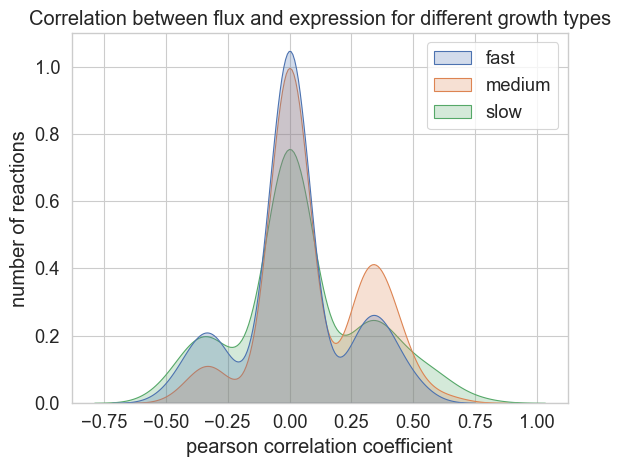

In [538]:
# calculate the p value for each growth types compare to medium growth type
from scipy.stats import ttest_ind
for growth_type in df_growth_type_corr.columns:
    print(growth_type,ttest_ind(df_growth_type_corr['medium'],df_growth_type_corr[growth_type])[1])

# plot the distribution of correlation for different growth types
sns.set_theme(context='paper',style='whitegrid',palette='deep',font='Arial',font_scale=1.5)
sns.kdeplot(data=df_growth_type_corr.loc[~(df_growth_type_corr==0).all(axis=1)],shade=True)
plt.xlabel('pearson correlation coefficient')
plt.ylabel('number of reactions')
plt.title('Correlation between flux and expression for different growth types')
plt.show()

In [539]:
# Prepare for enrichment analysis
# top=20
# fast_top_rxns=fast_flux_expression_r.loc[fast_flux_expression_r['p-value']<0.05,'correlation'].sort_values(ascending=False).index[:top].tolist()
# medium_top_rxns=medium_flux_expression_r.loc[medium_flux_expression_r['p-value']<0.05,'correlation'].sort_values(ascending=False).index[:top].tolist()
# slow_top_rxns=slow_flux_expression_r.loc[slow_flux_expression_r['p-value']<0.05,'correlation'].sort_values(ascending=False).index[:top].tolist()

threshold=0.2
fast_top_rxns=fast_flux_expression_r.loc[fast_flux_expression_r['correlation']>threshold,'correlation'].sort_values(ascending=False).index.tolist()
medium_top_rxns=medium_flux_expression_r.loc[medium_flux_expression_r['correlation']>threshold,'correlation'].sort_values(ascending=False).index.tolist()
slow_top_rxns=slow_flux_expression_r.loc[slow_flux_expression_r['correlation']>threshold,'correlation'].sort_values(ascending=False).index.tolist()
# # check the top rxn correlation value
print('fast:',fast_flux_expression_r.loc[fast_top_rxns[-1],'correlation'])
print('medium:',medium_flux_expression_r.loc[medium_top_rxns[-1],'correlation'])
print('slow:',slow_flux_expression_r.loc[slow_top_rxns[-1],'correlation'])

# prepare background
backgroud=flux_z_Matrix.index.tolist()

fast: 0.2830320056519442
medium: 0.2799088403301948
slow: 0.2797169861512408


In [540]:
# do enrichment analysis
from gseapy import barplot
def enr_analysis(rxnList,pathway_dict,background,title='enrichment analysis'):
    enr=gp.enrichr(gene_list=rxnList,
                   gene_sets=pathway_dict,
                   background=background,
                   outdir=None,
                   no_plot=True)
    
    # plot
    try:
        ax=barplot(enr.res2d,
                column='Adjusted P-value',
                    title=title,cutoff=0.05,figsize=(4,2))
    except:
        print('No significant enrichment')
    return enr.res2d


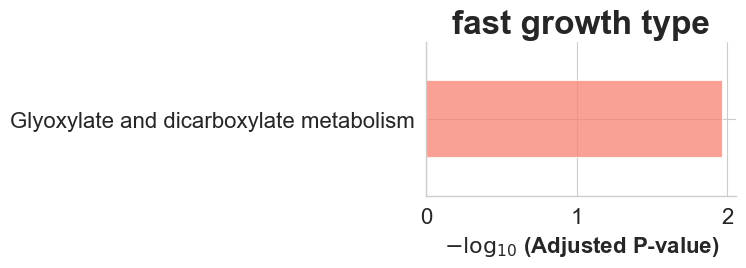

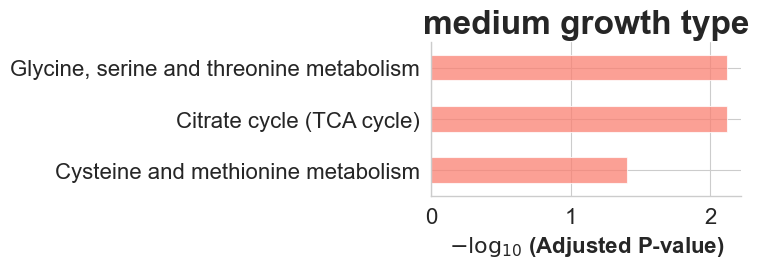

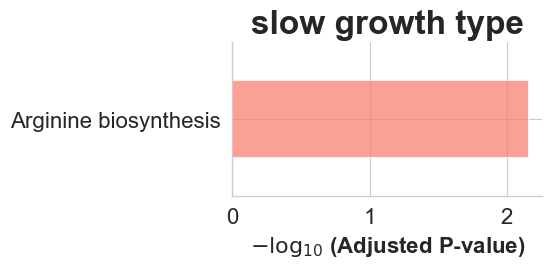

In [541]:
# fast growth type
fast_enr=enr_analysis(fast_top_rxns,pathway_dict,backgroud,title='fast growth type')
# medium growth type
medium_enr=enr_analysis(medium_top_rxns,pathway_dict,backgroud,title='medium growth type')
# slow growth type
slow_enr=enr_analysis(slow_top_rxns,pathway_dict,backgroud,title='slow growth type')

2024-11-25 09:08:42,031 [WARNING] Duplicated values found in preranked stats: 92.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-11-25 09:08:42,032 [INFO] Parsing data files for GSEA.............................
2024-11-25 09:08:42,032 [INFO] 0044 gene_sets have been filtered out when max_size=1000 and min_size=3
2024-11-25 09:08:42,033 [INFO] 0034 gene_sets used for further statistical testing.....
2024-11-25 09:08:42,034 [INFO] Start to run GSEA...Might take a while..................
2024-11-25 09:08:42,079 [INFO] Congratulations. GSEApy runs successfully................

2024-11-25 09:08:42,108 [WARNING] Duplicated values found in preranked stats: 89.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-11-25 09:08:42,109 [INFO] Parsing data files for GSEA.............................
2024-11-25 09:08:42,109 [INFO] 0044 gene_sets have been filtered out when max_size=1000 and min_size=3


no significant result
       Name                                               Term        ES  \
0   prerank                            Sphingolipid metabolism -0.633047   
1   prerank                                  Purine metabolism -0.722129   
2   prerank                            Glycerolipid metabolism -0.646667   
3   prerank             Nicotinate and nicotinamide metabolism -0.430108   
4   prerank                    Fructose and mannose metabolism -0.449679   
5   prerank  Phenylalanine, tyrosine and tryptophan biosynt...  0.953437   
6   prerank                          Citrate cycle (TCA cycle)  0.949227   
7   prerank                                  Lysine metabolism  0.995671   
8   prerank                                Thiamine metabolism -0.381974   
9   prerank                              Riboflavin metabolism  0.986985   
10  prerank                          Pentose phosphate pathway  0.967462   
11  prerank           Glycine, serine and threonine metabolism  0.

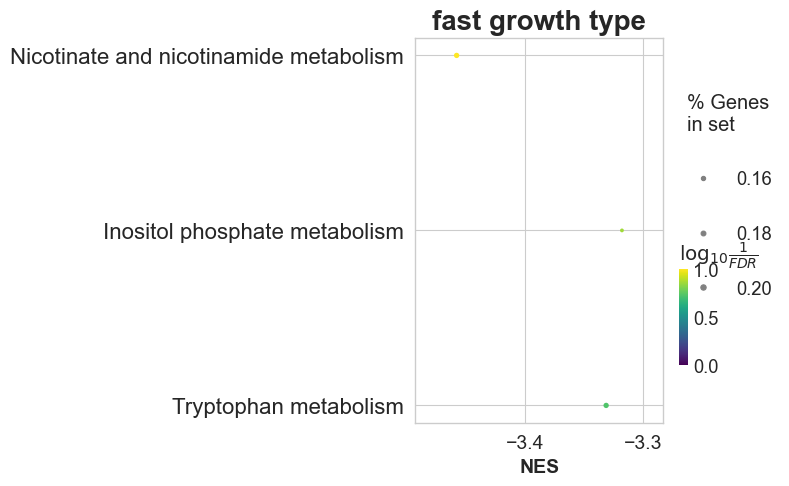

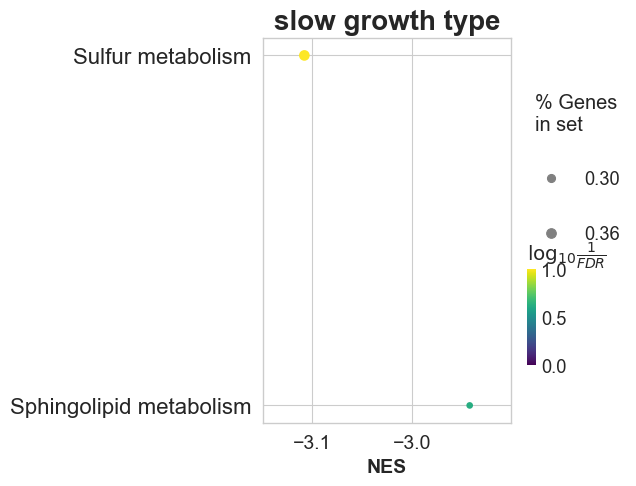

In [22]:
# prerank gsea analysis
def gsea_analysis(df_correlation,pathway_dict,title='pathway enrichment analysis'):
    # prepare the pre-ranked list
    df_rxn_list=df_correlation['correlation'].sort_values(ascending=False)
    df_rxn_list=pd.DataFrame(df_rxn_list)

    pre_res = gp.prerank(rnk=df_rxn_list, # or rnk = rnk,
                     gene_sets=pathway_dict,
                     min_size=3,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

    pre_res.res2d

    # plot
    try:
        ax = dotplot(pre_res.res2d,
                    #  column="NOM p-val", 
                    column='FDR q-val',
                    title=title,
                    cmap=plt.cm.viridis,
                    size=4, # adjust dot size
                    figsize=(4,5), 
                    cutoff=0.25,
                    show_ring=False)
    except:
        print('no significant result')
        print(pre_res.res2d)
    return pre_res.res2d

fast_gsea_result=gsea_analysis(df_correlation=fast_flux_expression_r,pathway_dict=pathway_dict,title='fast growth type')
medium_gsea_result=gsea_analysis(df_correlation=medium_flux_expression_r,pathway_dict=pathway_dict,title='medium growth type')
slow_gsea_result=gsea_analysis(slow_flux_expression_r,pathway_dict,title='slow growth type')

### 3.different clade analysis

In [23]:
# load all strain info
df_strain_info=pd.read_excel(r'data\1897_strains_info.xlsx',index_col=0)

# remove rows with NaN value in nature_clade
df_strain_info=df_strain_info[~df_strain_info['nature_clade'].isna()]

# only keep strain that exist in rxn_fcMatrix columns
df_strain_info=df_strain_info.loc[df_strain_info.index.isin(fluxMatrix.columns)]
df_strain_info['nature_clade'].value_counts()

1. Wine/European                 254
M3. Mosaic region 3               89
25. Sake                          46
8. Mixed origin                   40
26. Asian fermentation            37
1. Wine/European (subclade 4)     36
3. Brazilian bioethanol           33
10. French Guiana human           30
13. African palm wine             27
5. French dairy                   26
1. Wine/European (subclade 3)     22
7. Mosaic beer                    18
M2. Mosaic region 2               17
1. Wine/European (subclade 1)     17
2. Alpechin                       15
M3. Mosaic region 3               13
1. Wine/European (subclade 2)     13
12. West African cocoa            13
M1. Mosaic region 1               13
23. North American oak            13
6. African beer                   11
24. Asian islands                 10
21. Ecuadorean                     9
18. Far East Asia                  9
4. Mediterranean oak               8
9. Mexican agave                   7
11. Ale beer                       6
1

In [24]:
# wildtypelist=['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ', '24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian ']
wildtypelist=['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ','24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian ']
# only keep clades with more than 10 strains
check_cladelist=df_strain_info['nature_clade'].value_counts()[df_strain_info['nature_clade'].value_counts()>15].index.tolist()
wt_strainlist=df_strain_info[df_strain_info['nature_clade'].isin(wildtypelist)].index.tolist()
check_clades_dict=dict()
# sample 20 strains from wildtype
sample_number=15
random.seed(123)
# wt_strainlist=random.sample(wt_strainlist,sample_number)
check_clades_dict['wildtype']=wt_strainlist
print('wildtype',len(set(wt_strainlist)))
for clade in check_cladelist:
    strainlist=df_strain_info[df_strain_info['nature_clade']==clade].index.tolist()
    if len(strainlist)<sample_number:
        continue
    else:
        # sample 20 strains from each clade
        random.seed(123)
        # strainlist=random.sample(strainlist,sample_number)
        strainlist=strainlist
    check_clades_dict[clade]=strainlist
    print(clade,len(set(strainlist)))

wildtype 37
1. Wine/European  254
M3. Mosaic region 3 89
25. Sake  46
8. Mixed origin  40
26. Asian fermentation  37
1. Wine/European (subclade 4) 36
3. Brazilian bioethanol  33
10. French Guiana human  30
13. African palm wine  27
5. French dairy  26
1. Wine/European (subclade 3) 22
7. Mosaic beer  18
M2. Mosaic region 2 17
1. Wine/European (subclade 1) 17


In [25]:
df_clades_corr=pd.DataFrame(index=flux_z_Matrix.index)
for clade in check_clades_dict.keys():
    strainlist=check_clades_dict[clade]
    df_clades_corr[clade]=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,strainlist)['correlation']

# remove rows with all nan value
df_clades_corr.dropna(axis=0,how='all',inplace=True)
# remove rows with all 0 value
df_clades_corr=df_clades_corr.loc[(df_clades_corr.T!=0).sum()>0]

df_clades_corr.describe()

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,wildtype,1. Wine/European,M3. Mosaic region 3,25. Sake,8. Mixed origin,26. Asian fermentation,1. Wine/European (subclade 4),3. Brazilian bioethanol,10. French Guiana human,13. African palm wine,5. French dairy,1. Wine/European (subclade 3),7. Mosaic beer,M2. Mosaic region 2,1. Wine/European (subclade 1)
count,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000
mean,0.019350,0.054794,0.066547,0.071277,0.000774,0.063597,0.050559,0.017040,0.027027,0.025566,0.017258,0.008806,0.023095,0.011151,0.019767
std,0.175316,0.141909,0.171982,0.181741,0.162790,0.195199,0.191365,0.143113,0.171165,0.158902,0.134849,0.227017,0.183103,0.170696,0.147536
min,-0.539355,-0.445109,-0.354631,-0.417580,-0.536469,-0.414177,-0.515547,-0.594091,-0.627141,-0.524420,-0.502071,-0.754941,-0.572755,-0.671569,-0.593137
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.123855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.746885,0.712947,0.731043,0.748919,0.635035,0.748471,0.797690,0.786713,0.855112,0.694768,0.676390,0.813948,0.810263,0.793614,0.784633


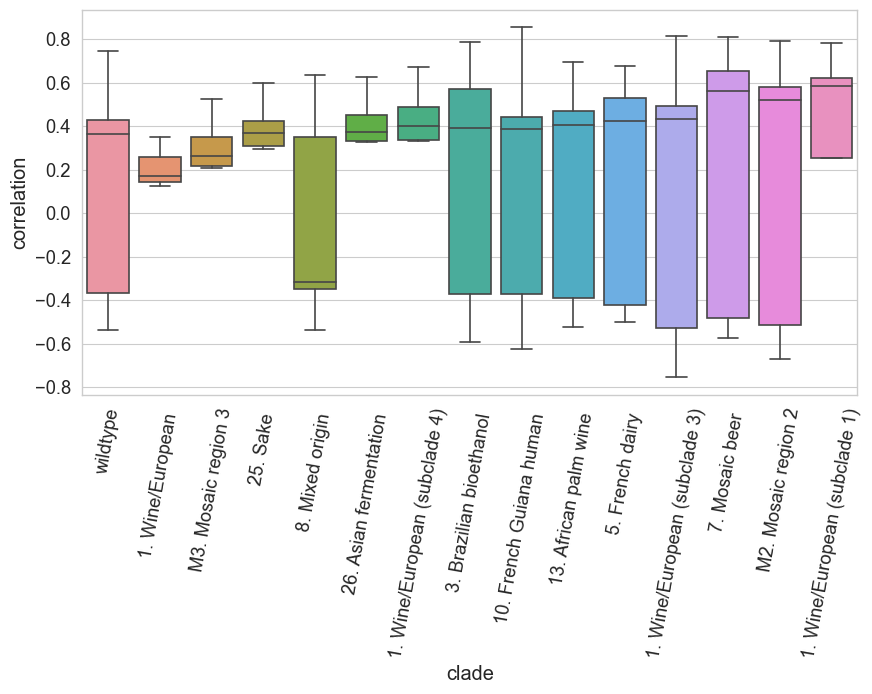

In [26]:
import seaborn as sns
# plot the boxplot of correlation for different clades
fig,ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=df_clades_corr[df_clades_corr!=0],ax=ax,showfliers=False)
plt.xlabel('clade')
plt.ylabel('correlation')
plt.xticks(rotation=80)
plt.show()

In [27]:
# do enrichment analysis for high correlation reactions
def enr_analysis(rxnList,pathway_dict,background=None,cutoff=0.05):
    enr=gp.enrich(gene_list=rxnList, # or gene_list=glist
                 gene_sets=pathway_dict,
                 background=background, 
                 outdir=None,
                 verbose=None)
    result=enr.res2d
    result=result[result['P-value']<cutoff]
    # set Term as index
    result=result.set_index('Term')
    return result

In [28]:
threshold=0.2
high_corr_rxn_dict=dict()
# check the number of reactions with correlation > threshold
for clade in df_clades_corr.columns:
    print(clade,df_clades_corr.loc[df_clades_corr[clade]>threshold].shape[0])
    high_corr_rxn_dict[clade]=df_clades_corr.loc[df_clades_corr[clade]>threshold].index.tolist()
    # get the top 20 reactions
    # high_corr_rxn_dict[clade]=df_clades_corr.loc[df_clades_corr[clade]>threshold].sort_values(by=clade,ascending=False).index.tolist()[:20]
    # print(clade,high_corr_rxn_dict[clade][-1])


backgroud=fluxMatrix.index.tolist()

wildtype 33
1. Wine/European  34
M3. Mosaic region 3 81
25. Sake  65
8. Mixed origin  27
26. Asian fermentation  59
1. Wine/European (subclade 4) 49
3. Brazilian bioethanol  18
10. French Guiana human  33
13. African palm wine  27
5. French dairy  18
1. Wine/European (subclade 3) 32
7. Mosaic beer  20
M2. Mosaic region 2 17
1. Wine/European (subclade 1) 15


In [29]:
# do enrichment analysis of high correlation reactions for each clade
df_clades_score=pd.DataFrame(index=pathway_dict.keys())
df_clades_pvalue=pd.DataFrame(index=pathway_dict.keys())
for clade in high_corr_rxn_dict.keys():
    rxnList=high_corr_rxn_dict[clade]
    result=enr_analysis(rxnList,pathway_dict,backgroud,cutoff=0.05)
    df_clades_score[clade]=result['Combined Score']
    df_clades_pvalue[clade]=result['P-value']

# remove rows with all nan value
df_clades_score.dropna(axis=0,how='all',inplace=True)
# fill nan value with 0
df_clades_score.fillna(0,inplace=True)
df_clades_score


,wildtype,1. Wine/European,M3. Mosaic region 3,25. Sake,8. Mixed origin,26. Asian fermentation,1. Wine/European (subclade 4),3. Brazilian bioethanol,10. French Guiana human,13. African palm wine,5. French dairy,1. Wine/European (subclade 3),7. Mosaic beer,M2. Mosaic region 2,1. Wine/European (subclade 1)
"Alanine, aspartate and glutamate metabolism",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,28.412517,0.00000,0.0,0.000000,0.000000
Citrate cycle (TCA cycle),113.642366,33.742129,26.054542,0.000000,0.000000,9.703562,28.473651,0.000000,0.000000,0.0,0.000000,0.00000,0.0,28.785595,0.000000
Cysteine and methionine metabolism,19.379005,0.000000,0.000000,0.000000,28.445167,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,27.125684
Folate biosynthesis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.859826,0.0,0.000000,0.00000,0.0,0.000000,0.000000
"Glycine, serine and threonine metabolism",0.000000,0.000000,12.623325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
Glycolysis / gluconeogenesis,0.000000,0.000000,0.000000,10.664831,0.000000,24.038973,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
Glyoxylate and dicarboxylate metabolism,370.909167,354.603694,0.000000,126.760740,0.000000,149.047268,0.000000,902.223345,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
Histidine metabolism,0.000000,0.000000,28.593829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
Lysine metabolism,0.000000,0.000000,0.000000,158.230869,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
"Phenylalanine, tyrosine and tryptophan biosynthesis",0.000000,0.000000,255.155290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000


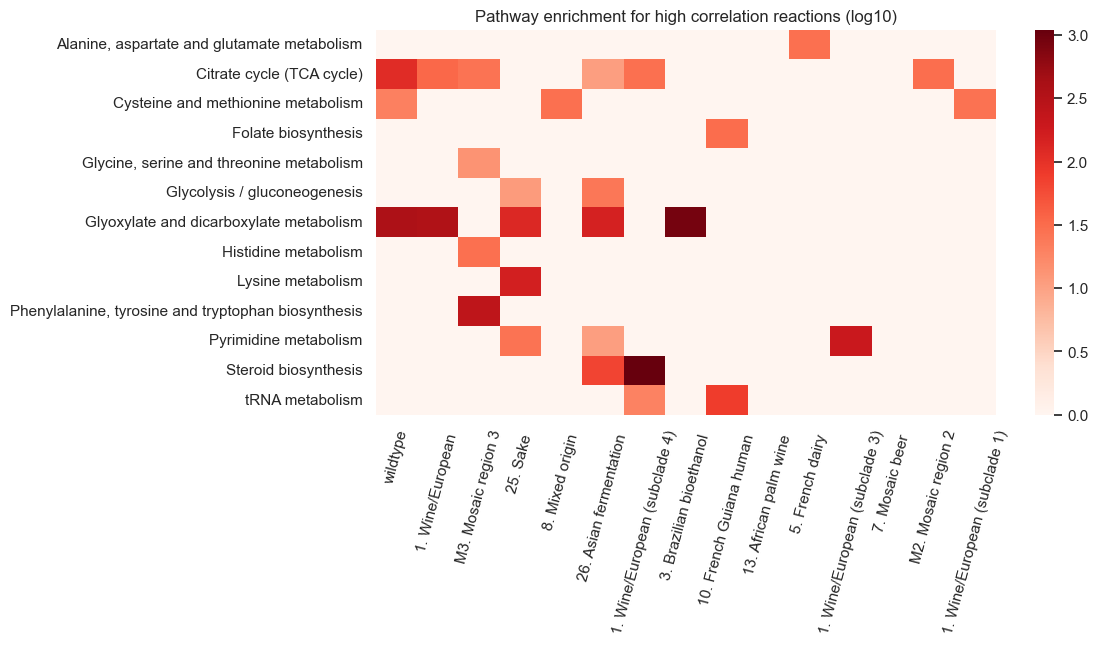

In [30]:
# plot the enrichment score as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# set font style as Arial
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(10, 5))
df_clades_score_log=np.log10(df_clades_score+1)
sns.heatmap(df_clades_score_log, cmap="Reds")
plt.title('Pathway enrichment for high correlation reactions (log10)')
plt.xticks(rotation=75)
# # set color bar title
# cbar = plt.gca().collections[0].colorbar
# cbar.set_label('Enrichment score (log10)')
plt.show()